# LSTM Experiment

This notebook is an entry point to reproduce the experiments describe in the LSTM section of the paper.

It consists of three sections:

    1) Data Loading
    2) Example on how to train and test a LSTM on our data
    3) The actual experiment code from the paper


In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# For use in google colab
!pip install python-Levenshtein

In [3]:
import DataSet
import Evaluation
import datetime
import numpy as np 
import matplotlib.pyplot as plt
import random
from matplotlib.backends.backend_pdf import PdfPages

from Utils import *

from DataSet import UniHHIMUGestures
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
def getProjectPath():
    return './'

We need to specify a bunch of parameters the expriment:

In [7]:
#===========================================================================
# Give this run a name. 
# If name equals 'test', no log will be generated
#===========================================================================
name = 'test'


#===========================================================================
# Decide which gesture data shall be used for training
#===========================================================================
inputGestures = [0,1,2,3,4,5,6,7,8,9]

#===========================================================================
# Decide which target signals shall be used for training
#===========================================================================
usedGestures = [0,1,2,3,4,5,6,7,8,9]

#===========================================================================
# Concatenate data to create "more" training samples, 1 corresponds to no concatenations
#===========================================================================
concFactor = 1

#===========================================================================
# Add noise to the data, 0 corresponds to no noise. Noise above 2 has shown to weaken recognition
#===========================================================================
noiseFactor = 1

#===========================================================================
# Decide wether gestures shall be shuffled before training. If true, nFolds many 
# pieces will be generated. Not every piece is garanteed to contain every gesture, so do not use too many.
#===========================================================================
shuffle = True
nFolds = 4


#===========================================================================
# Function used to evaluate during cross validation. Possible functions are:
# Evaluation.calc1MinusF1FromMaxApp (best working, used in thesis)
# Oger.utils.nmse (normalised mean square error, tells nothing about classifier perfomance but works okay)
# Evaluation.calcLevenshteinError (use the Levenshtein error, disadvantages are highlighted in thesis) 
# Evaluation.calc1MinusF1FromInputSegment (use segmentation by supervised signal)
#===========================================================================
evaluationFunction = Evaluation.calc1MinusF1FromMaxApp

#===========================================================================
# Set this to true if another output neuron shall be added to represent "no gesture"
#===========================================================================
learnTreshold = False

#===========================================================================
# Use on of the optimisation dictionaries from the optDicts file
#===========================================================================
optDict = 'bestParas'

#===========================================================================
# Use normalizer
#===========================================================================
useNormalized = 2

#===========================================================================
# Pick datasets to train on, and datasets to test on
#===========================================================================
inputFiles = ['nike','julian','nadja','line']
testFiles = ['stephan']

# If desired add a specific file to test on, e.g. randTestFiles = ['lana_0_0.npz']
randTestFiles = []



#===========================================================================
# Setup project directory
#===========================================================================
now = datetime.datetime.now()
resultsPath = getProjectPath()+'results/'
pdfFileName = now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.pdf'
pdfFilePath = resultsPath+'pdf/'+pdfFileName
npzFileName = now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.npz'
npzFilePath = resultsPath+'npz/'+npzFileName
bestFlowPath = resultsPath+'nodes/'+now.strftime("%Y-%m-%d-%H-%M")+'_'+name+'.p'
pp = PdfPages(pdfFilePath)


#===========================================================================
# Add labels for gestures
#===========================================================================
totalGestureNames = ['left','right','forward','backward','bounce up','bounce down',
                     'turn left','turn right','shake lr','shake ud',
                     'tap 1','tap 2','tap 3','tap 4','tap 5','tap 6','no gesture']
gestureNames = []
for i in usedGestures:
    gestureNames.append(totalGestureNames[i])
gestureNames.append('no gesture')

Create dataset and dataloaders

In [8]:
def createData(inputFiles, testFiles, validation_size=10):
    trainset_ = UniHHIMUGestures(dataDir=getProjectPath() + 'dataSets/', 
                                train=True, 
                                inputFiles=inputFiles,
                                testFiles=testFiles,
                                useNormalized=useNormalized, 
                                learnTreshold=learnTreshold,
                                nFolds=100,
                                shuffle=True,
                               )

    testset = UniHHIMUGestures(dataDir=getProjectPath() + 'dataSets/', 
                               train=False, 
                               inputFiles=inputFiles,
                               testFiles=testFiles,
                               useNormalized=useNormalized, 
                               learnTreshold=learnTreshold,
                               shuffle=True
                              )
    
    trainset, validationset = torch.utils.data.random_split(trainset_, [len(trainset_)-validation_size,validation_size])
    

    trainloader = DataLoader(trainset, batch_size=1,
                            shuffle=True, num_workers=1)
    validationloader = DataLoader(validationset, batch_size=1,
                                shuffle=True, num_workers=1)
    testloader = DataLoader(testset, batch_size=1,
                            shuffle=True, num_workers=1)
    return trainset, validationset, testset, trainloader, validationloader, testloader
    
trainset, validationset, testset, trainloader, validationloader, testloader = createData(inputFiles, testFiles)

Let's take a look at the scaled input data:

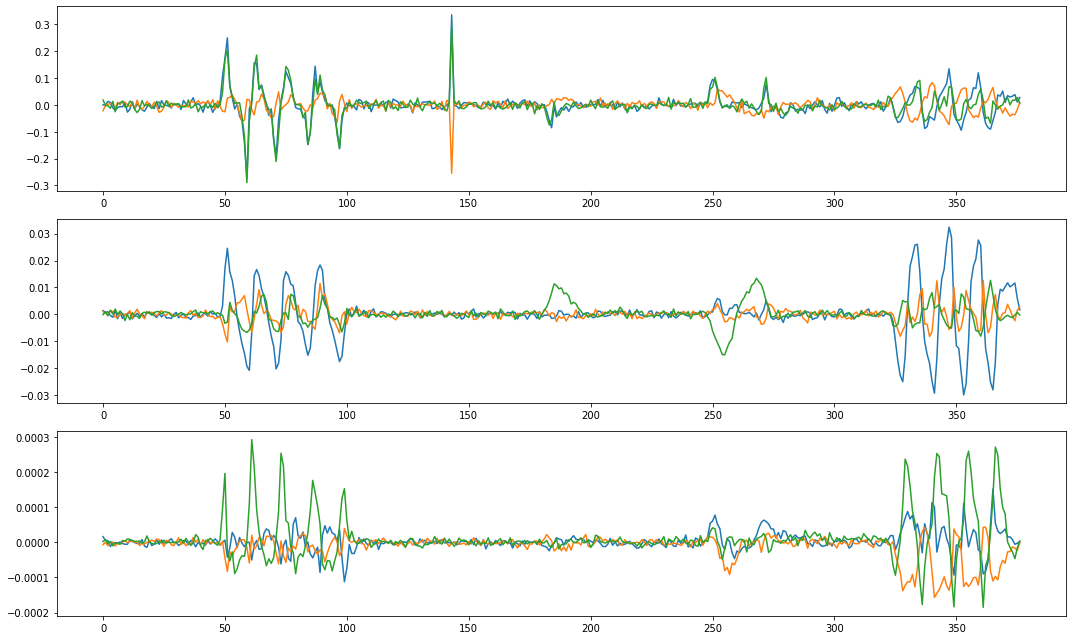

In [9]:
fig, ax = plt.subplots(3,1, figsize=(15,9))
ax[0].plot(trainset[0][0][:800,0:3])
ax[1].plot(trainset[0][0][:800,3:6])
ax[2].plot(trainset[0][0][:800,6:9])
plt.tight_layout()

Looks all good, we can clearly see the gesture sequences intercepted by non gesture seqeuences in between.
Now let's create a Leaky Integrator ESN with parameters as defined in the paper.

## Section 2: Train and test LSTM

This section shows how to create and train LSTM on the give data.

In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self, hidden_dim=25):
        super(LSTMClassifier, self).__init__()
        
        self.lstm = torch.nn.LSTM(input_size=9, hidden_size=hidden_dim, batch_first=True)
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,10, bias=False),
            #torch.nn.Sigmoid()
        )


    def forward(self, inputs):
        lstm_outputs, (hidden_acts, cell_states) = self.lstm(inputs)
        
        predictions = self.classifier(lstm_outputs)
        return predictions

In [ ]:
lstm = LSTMClassifier(20)
loss_function = torch.nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=1e-3)

lstm.cuda()

In [ ]:
import sklearn


def testLSTM(testloader, lstm, plot=True, plotConf=False):
    testF1MaxApps = []
    testAccuracies = []
    testCms = []
    losses = []
    for inputs, targets in testloader:
        test_inputs, test_targets = inputs.float(), targets.float()
        
        #inputs[0,:,:9] = targets[0,:,:9]
        test_inputs = (test_inputs/test_inputs.std(1))
        
        test_inputs = test_inputs.cuda()
        test_targets = test_targets.cuda()

        lstm.eval()


        outputs = lstm(test_inputs)
        loss = loss_function(outputs, test_targets)
        losses.append(loss.item())

        test_preds = outputs.cpu().detach().numpy()[0]

        if plot:
            plt.figure(figsize=(15,5))
            plt.plot(test_preds[:1600,:])
            plt.plot(test_targets[0,:1600,:].cpu())
            plt.pause(1)
        
        fixed_threshold = 0.4

        t_target = test_targets[0].cpu().numpy()
        prediction = test_preds[:,:10]
        if learnTreshold: # if threshold is learned, then it's the las collumn of the prediction
            threshold = outputs[0].numpy()[:,10]
        else: #else add a constant threshold
            threshold = np.ones((prediction.shape[0],1))*fixed_threshold

        t_maxApp_prediction = Evaluation.calcMaxActivityPrediction(prediction,t_target,threshold, 10)


        pred_MaxApp, targ_MaxApp = Evaluation.calcInputSegmentSeries(t_maxApp_prediction, t_target, 0.5)
        testF1MaxApps.append(np.mean(sklearn.metrics.f1_score(targ_MaxApp,pred_MaxApp,average=None)))
        testAccuracies.append(np.mean(sklearn.metrics.accuracy_score(targ_MaxApp,pred_MaxApp)))

        if False:
        #print(t_maxApp_prediction.shape, prediction.shape, pred_MaxApp, targ_MaxApp)
            plt.figure(figsize=(20,3))
            plt.plot(t_maxApp_prediction[:800])
            plt.plot(t_target[:800])


        conf = sklearn.metrics.confusion_matrix(targ_MaxApp, pred_MaxApp)
        testCms.append(conf)

        if plotConf:
            Evaluation.plot_confusion_matrix(testCms[0], gestureNames, 'test set')
            plt.tight_layout()
            plt.ylim(10.5,-0.5)

    #print("Test f1 score for maxactivity: {:.4f}, MSE: {:.4f}".format(np.mean(testF1MaxApps),loss.item()))

    return np.mean(testF1MaxApps), np.mean(losses), np.mean(testAccuracies), testCms

testLSTM(testloader, lstm)

In [ ]:
import copy



def trainLSTM(inputFiles, testFiles, plot=True):
    trainset, validationset, testset, trainloader, validationloader, testloader = createData(inputFiles, testFiles)

    
    lstm = LSTMClassifier(80)
    loss_function = torch.nn.MSELoss()
    optimizer = optim.Adam(lstm.parameters(), lr=1e-3)

    lstm.cuda()

    best_score = 0.
    best_model = lstm.state_dict()

    train_losses = []
    test_losses = []
    test_scores = []

    for epoch in range(100):
        epoch_losses = []
        for inputs, targets in trainloader:
            lstm.train()
            inputs, targets = inputs.float(), targets.float()
            
            #inputs[0,:,:9] = targets[0,:,:9]
            inputs = (inputs/inputs.std(1))
            
            inputs = inputs[:,:,:].cuda()
            targets = targets[:,:,:].cuda()

            lstm.zero_grad()

            outputs =  lstm(inputs)


            loss = loss_function(outputs, targets)
            loss.backward()
            
            epoch_losses.append(loss.item())
            
            optimizer.step()
        
        train_losses.append(epoch_losses)

        score, mse, accuracies, cm = testLSTM(validationloader, lstm, plot=False)
        test_losses.append(mse.item())
        test_scores.append(score.item())

        if score > best_score:
            best_model = copy.deepcopy(lstm.state_dict())
            torch.save(lstm.state_dict(), 'weights_only.pth')
            best_score = score
        if score + 0.1 < best_score:
            print('Overfitted, breaking the loop')
            break

        if epoch % 25 == 0:
            print(loss.item())
            lstm.eval()
            plt.figure(figsize=(15,5))
            plt.title('Epoch: {:}, loss: {:.4f}'.format(epoch, loss))
            #test_preds = lstm(test_inputs.float()).detach().numpy()[0]
            #plt.plot(test_preds[:800,:])
            #plt.plot(test_targets[0,:800,:])
            preds = lstm(inputs)
            if plot:
                plt.plot(preds[0,:800].cpu().detach())
                plt.plot(targets[0,:800].cpu().detach())
                plt.ylim(-0.1,1.1)
                plt.pause(1)
            score, mse, accuracies, cm = testLSTM(validationloader,lstm,  plot=False)
            print("Best score: {:.2f}, current score: {:.2f}".format(best_score, score, mse))


    plt.plot([np.mean(epoch_losses) for epoch_losses in train_losses])
    plt.plot([x for x in test_losses])
    
    lstm.load_state_dict(best_model)

    train_score, train_mse, train_accuracy, train_cm = testLSTM(trainloader, lstm,  plot=False, plotConf=False)
    score, mse, accuracy, cm = testLSTM(testloader, lstm,  plot=plot, plotConf=plot)
    print("Best score: {:.2f}, current score: {:.2f}".format(best_score, score, mse))

    print('###################################################################')

    return score, mse, accuracy, cm, train_score, train_mse, train_accuracy, lstm

In [ ]:
inputFiles = ['stephan','nike','nadja','line']
testFiles = ['julian']

scores = []



for trial in range(1):
    print('################# TRIAL: {} #########################'.format(trial))
    score, mse, accuracy, cm, train_score, train_mse, train_accuracy, lstm = trainLSTM(inputFiles=inputFiles, testFiles=testFiles, plot=True)
    scores.append(score)

In [ ]:
best_lstm = LSTMClassifier(80)
best_lstm.load_state_dict(torch.load('weights_only.pth'))
best_lstm.cuda().eval()

testLSTM(testloader, best_lstm, plot=True, plotConf=True)

In [ ]:
score, mse, accuracies, cms = testLSTM(testloader, best_lstm,  plot=True)


## Section 3: Run experiment from paper

In this experiment we train an LSTM on four of the testsets and evaluate on the fith one. Training and evaluation is repeated several times to average the results.

In [ ]:
# Prepare arrays to store evaualtion results

files = ['stephan','julian','nadja','line','nike']

trials = 10

if False:
    all_scores = np.zeros((len(files),trials))
    all_train_scores = np.zeros((len(files),trials))
    all_cms = np.zeros((len(files),trials, 11, 11))
    all_accuracies = np.zeros((len(files),trials))
    all_train_accuracies = np.zeros((len(files),trials))

    np.save(file=getProjectPath()+"lstm_scores", arr=np.array(all_scores))
    np.save(file=getProjectPath()+"lstm_train_scores", arr=np.array(all_train_scores))
    np.save(file=getProjectPath()+"lstm_cms", arr=np.array(all_cms))
    np.save(file=getProjectPath()+"lstm_accuracies", arr=np.array(all_accuracies))
    np.save(file=getProjectPath()+"lstm_train_accuracies", arr=np.array(all_train_accuracies))



In [ ]:
if False:
    all_scores = np.load("lstm_scores.npy")
    all_train_scores = np.load("lstm_train_scores.npy")
    all_cms = np.load("lstm_cms.npy")
    all_accuracies = np.load("lstm_accuracies.npy")
    all_train_accuracies = np.load("lstm_train_accuracies.npy")


In [ ]:
from tqdm import tqdm_notebook

def fix_seed(manualSeed):
    
    np.random.seed(manualSeed)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    # if you are using GPU
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)

In [ ]:
# run evaluation for each testset

fix_seed(1)

start_ind=0

for idx in tqdm_notebook(range(int(start_ind/trials) ,5)):
    scores = []
    train_scores = []
    accuracies = []
    networks = []
    
    # Shuffle testsets
    inputFiles = files[:idx] + files[idx+1:]
    testFiles = files[idx:idx+1]


    for t in tqdm_notebook(range(int(start_ind%trials),trials)):
        print('Exp id:', idx, t)
        score, mse, accuracy, cm, train_score, train_mse, train_accuracy, lstm = \
            trainLSTM(inputFiles=inputFiles, testFiles=testFiles, plot=False)

        all_scores[idx,t] = score
        all_train_scores[idx,t] = train_score
        all_accuracies[idx,t] = accuracy
        all_train_accuracies[idx,t] = train_accuracy
        all_cms[idx,t] = cm[0]


        #np.save(file=getProjectPath()+"lstm_scores", arr=np.array(all_scores))
        #np.save(file=getProjectPath()+"lstm_train_scores", arr=np.array(all_train_scores))
        #np.save(file=getProjectPath()+"lstm_cms", arr=np.array(all_cms))
        #np.save(file=getProjectPath()+"lstm_accuracies", arr=np.array(all_accuracies))
        #np.save(file=getProjectPath()+"lstm_train_accuracies", arr=np.array(all_train_accuracies))


In [ ]:
# print results
import pandas as pd
pd.DataFrame(np.vstack([
        all_accuracies.mean(1),
        all_accuracies.std(1),
        all_train_accuracies.mean(1),
        all_train_accuracies.std(1),
        all_scores.mean(1),
        all_scores.std(1),
        all_train_scores.mean(1),
        all_train_scores.std(1),
    ]), 
    columns=files, 
    index=['accuracies','accuracies_std','accuracies_train','accuracies_train_std','f1','f1_std','f1_train','f1_train_std'])

In [ ]:
all_scores.mean(), all_scores.std(), all_accuracies.mean(), all_accuracies.std(), all_train_scores.mean(), all_train_scores.std(),


## Additional methods and figures

In [ ]:
score, mse, accuracy, cm, train_score, train_mse, train_accuracy, lstm = \
            trainLSTM(inputFiles=inputFiles, testFiles=testFiles, plot=True)

#testLSTM(testloader,lstm)

In [ ]:
trainset, validationset, testset, trainloader, validationloader, testloader = createData(inputFiles, testFiles)
score, mse, accuracy, cm = testLSTM(testloader, lstm,  plot=True, plotConf=True)


In [ ]:
# plot median confustion matrices

from Evaluation import plot_confusion_matrix


median_cms = []
for i, (testfile, scores, cms) in enumerate(zip(files, all_scores, all_cms)):
    print(i, testfile)
    # get median model
    median_idx = np.argsort(scores)[round(len(scores)/2)]
    median_idx.argsort
    median_score = scores[median_idx]
    median_cm = cms[median_idx]
    median_cms.append(median_cm)
    fig = plot_confusion_matrix(median_cm.astype('int'), gestures=totalGestureNames[:10] + totalGestureNames[-1:])
    fig.tight_layout(pad=3.0)
    pp = PdfPages('figures/lstm_experiment_{}_f1_score_{:.2f}.pdf'.format(testfile, median_score))
    pp.savefig()
    pp.close()
    plt.savefig('figures/lstm_experiment_{}_f1_score_{:.2f}.eps'.format(testfile, median_score), format='eps')


In [ ]:
# plot average confusion matrices

from Evaluation import plot_confusion_matrix


median_cms = []
for i, (testfile, scores, cms) in enumerate(zip(files, all_scores, all_cms)):
    print(i, testfile)
    # get median model
    median_idx = np.argsort(scores)[round(len(scores)/2)]
    median_idx.argsort
    median_score = scores[median_idx]
    median_cm = cms[median_idx]
    median_cms.append(median_cm)
    fig = plot_confusion_matrix(cms.mean(0), gestures=totalGestureNames[:10] + totalGestureNames[-1:])
    fig.tight_layout(pad=3.0)
    pp = PdfPages('figures/lstm_experiment_{}_avg__f1_score_{:.2f}.pdf'.format(testfile, scores.mean()))
    pp.savefig()
    pp.close()
    plt.savefig('figures/lstm_experiment_{}_avg_f1_score_{:.2f}.eps'.format(testfile, scores.mean()), format='eps')


In [ ]:
inputFiles = [ 'julian', 'nadja', 'line', 'nike']
testFiles = ['stephan']
trainset, validationset, testset, trainloader, validationloader, testloader = createData(inputFiles, testFiles)
plt.figure(figsize=(15,5))
plt.plot(testset[0][1][:,9])

In [ ]:
# create activations plot

import matplotlib
old_font = matplotlib.rcParams.get('font.size')
matplotlib.rcParams.update({'font.size': 20})
    

for inputs, targets in testloader:
    test_inputs, test_targets = inputs.float(), targets.float()
    
    #inputs[0,:,:9] = targets[0,:,:9]
    test_inputs = (test_inputs/test_inputs.std(1))
    
    test_inputs = test_inputs.cuda()
    test_targets = test_targets.cuda()

    lstm.eval()


    outputs = lstm(test_inputs)
    loss = loss_function(outputs, test_targets)
    #losses.append(loss.item())

    test_preds = outputs.cpu().detach().numpy()[0]

    if True:
        plt.figure(figsize=(15,6))
        for signal, target, name in zip(test_preds.T,test_targets[0].T, gestureNames):
            plt.plot(signal[0:480], label=name)
            plt.fill_between(np.arange(480), np.zeros(480), target[0:480,].cpu(), alpha=0.05)
        plt.plot(test_targets[0,0:480,:].cpu())
        plt.xlim(0,700)
        #plt.pause(1)
        plt.legend()
        plt.xlabel('Timesteps')
        plt.ylabel('Activation')
    
    fixed_threshold = 0.4

    t_target = test_targets[0].cpu().numpy()
    prediction = test_preds[:,:10]
    if learnTreshold: # if threshold is learned, then it's the las collumn of the prediction
        threshold = outputs[0].numpy()[:,10]
    else: #else add a constant threshold
        threshold = np.ones((prediction.shape[0],1))*fixed_threshold

    t_maxApp_prediction = Evaluation.calcMaxActivityPrediction(prediction,t_target,threshold, 10)


    pred_MaxApp, targ_MaxApp = Evaluation.calcInputSegmentSeries(t_maxApp_prediction, t_target, 0.5)
    #testF1MaxApps.append(np.mean(sklearn.metrics.f1_score(targ_MaxApp,pred_MaxApp,average=None)))
    #testAccuracies.append(np.mean(sklearn.metrics.accuracy_score(targ_MaxApp,pred_MaxApp)))

    if False:
    #print(t_maxApp_prediction.shape, prediction.shape, pred_MaxApp, targ_MaxApp)
        plt.figure(figsize=(20,3))
        plt.plot(t_maxApp_prediction[:800])
        plt.plot(t_target[:800])


    conf = sklearn.metrics.confusion_matrix(targ_MaxApp, pred_MaxApp)
    #testCms.append(conf)

matplotlib.rcParams.update({'font.size': old_font})
    
pp = PdfPages('figures/subgesture.pdf'.format(testfile, scores.mean()))
pp.savefig()
pp.close()
plt.savefig('figures/subgesture.eps'.format(testfile, scores.mean()), format='eps')


In [ ]:
plt.plot(targets[0])

In [ ]:
(targets[0,:-1] < targets[0,1:]).sum(0)